In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch.nn as nn
import torch.optim as optim
import numpy as np
import shap
import pandas as pd

# respective classes for a label
classes = {
    0 : "sadness",
    1 : "joy",
    2 : "love",
    3 : "anger",
    4 : "fear",
    5 : "surprise"
}

def get_embedding(text, model_name):
    
    tokenizer = AutoTokenizer.from_pretrained(model_name + "_finetuned_emotion")
    model = AutoModelForSequenceClassification.from_pretrained(model_name + "_finetuned_emotion")
    model.eval()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs,  output_hidden_states=True)

    # Extract hidden states
    hidden_states = outputs.hidden_states

    if model_name in ["bert", "roberta"]:
    # Get CLS token embedding (pooled output)
        cls_embedding = hidden_states[-1][:, 0, :]  # (batch_size, hidden_dim)

    elif model_name == "xlnet":
    # XLNet doesn't have CLS token, so take last token's hidden state
        cls_embedding = hidden_states[-1][:, -1, :] 
    
    logits = outputs.logits  # Raw model outputs before softmax
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return cls_embedding.numpy(), predicted_class

# explanation : https://chatgpt.com/share/67dd43dc-27d4-8002-bae8-fc18bc074e0d


def get_combined_embeddings(text):
    bert_emb, pc1 = get_embedding(text, "bert")
    roberta_emb, pc2 = get_embedding(text, "roberta")
    xlnet_emb, pc3 = get_embedding(text, "xlnet")
    
    # Concatenate all three embeddings
    combined_embedding = torch.cat([
        torch.tensor(bert_emb), 
        torch.tensor(roberta_emb), 
        torch.tensor(xlnet_emb)
    ], dim=1)

    return combined_embedding.squeeze(0).numpy(), pc1, pc2, pc3

In [ ]:

class StackingNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(StackingNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, 768)  
        self.bn1 = nn.BatchNorm1d(768)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(768, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)

        self.fc4 = nn.Linear(256, num_classes)  # Output layer
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)  # No activation for output layer (CrossEntropyLoss expects raw logits)
        return x
    

# Model Initialization
input_dim = 2304
model = StackingNN(input_dim, 6)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


In [4]:

# classifier.load_state_dict(torch.load("best_model.pth"))
classifier = torch.load("best_model.pth", weights_only=False)
classifier.eval()

texts = ["im feeling dazed and alot of things in my mind",
         "i always feel so pressured",
         "i electrocuted my thumb and i cant type too well because i cant really you know feel some of my fingers as an acceptable excuse for a late paper",
         "im making some more mood icons right now to let you see how i feel and think and of course its all charming",
         "Many people eat cereal for breakfast"]

for sample_text in texts:

    embedding, predicted_class_bert, predicted_class_roberta, predicted_class_xlnet = get_combined_embeddings(sample_text)
    embedding_tensor = torch.tensor(embedding, dtype=torch.float32)
    embedding_tensor = embedding_tensor.view(1, -1)
    output = classifier(embedding_tensor)
    probabilities = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    print(f"Sentence -- {sample_text}")
    print("Predicted Class:", classes[predicted_class])
    print("Predicted Class bert:", classes[predicted_class_bert])
    print("Predicted Class roberta:", classes[predicted_class_roberta])
    print("Predicted Class xlnet:", classes[predicted_class_xlnet])
    print()


Sentence -- im feeling dazed and alot of things in my mind
Predicted Class: surprise
Predicted Class bert: surprise
Predicted Class roberta: surprise
Predicted Class xlnet: fear

Sentence -- i always feel so pressured
Predicted Class: fear
Predicted Class bert: fear
Predicted Class roberta: fear
Predicted Class xlnet: fear

Sentence -- i electrocuted my thumb and i cant type too well because i cant really you know feel some of my fingers as an acceptable excuse for a late paper
Predicted Class: joy
Predicted Class bert: joy
Predicted Class roberta: joy
Predicted Class xlnet: sadness

Sentence -- im making some more mood icons right now to let you see how i feel and think and of course its all charming
Predicted Class: joy
Predicted Class bert: joy
Predicted Class roberta: joy
Predicted Class xlnet: joy

Sentence -- Many people eat cereal for breakfast
Predicted Class: anger
Predicted Class bert: anger
Predicted Class roberta: joy
Predicted Class xlnet: fear



C:\Users\Abhinav Reddy\AppData\Local\Temp\ipykernel_21044\2801339062.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  background_embeddings = torch.tensor(background_embeddings, dtype=torch.float32, requires_grad=True)


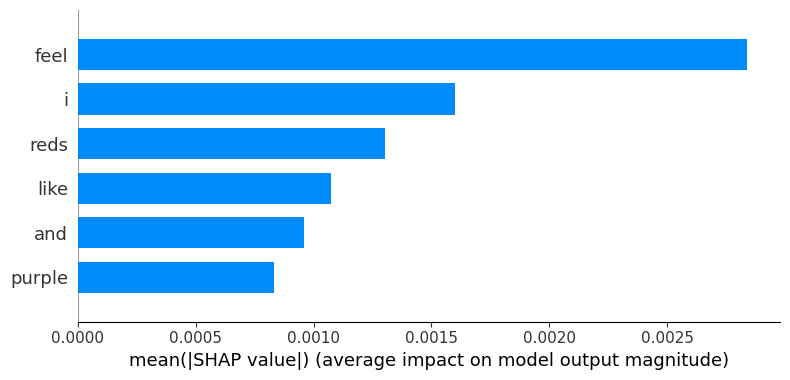

In [5]:

# SHAP Deep Explainer for Stacked Embeddings
def explain_prediction(text, classifier):
    class ModelWrapper(nn.Module):
        def __init__(self, model):
            super(ModelWrapper, self).__init__()
            self.model = model

        def forward(self, inputs_tensor):  
            # Ensure input is a tensor and requires gradients
            if not isinstance(inputs_tensor, torch.Tensor):
                inputs_tensor = torch.tensor(inputs_tensor, dtype=torch.float32, requires_grad=True)
            else:
                inputs_tensor.requires_grad_()  # Enable gradient computation

            logits = self.model(inputs_tensor)
            return logits

    # Wrap the classifier
    model_wrapper = ModelWrapper(classifier)
    
    # Ensure model is in training mode for SHAP to work
    classifier.train()

    # Prepare background embeddings (convert text to embeddings)
    df = pd.read_csv("training.csv")
    background_texts = df.iloc[:, 0].dropna().tolist()[:100]

    background_embeddings = []
    for t in background_texts:
        combined_emb, _, _, _ = get_combined_embeddings(t)
        background_embeddings.append(combined_emb)

    background_embeddings = torch.tensor(background_embeddings, dtype=torch.float32, requires_grad=True)

    # Convert input text into embedding
    text_embedding, _, _, _ = get_combined_embeddings(text)
    text_tensor = torch.tensor([text_embedding], dtype=torch.float32, requires_grad=True)  # Add batch dimension

    # Initialize DeepExplainer
    explainer = shap.DeepExplainer(model_wrapper, background_embeddings)

    # Compute SHAP values (Pass tensor, not text)
    shap_values = explainer.shap_values(text_tensor)

    tokenizer = AutoTokenizer.from_pretrained("bert_finetuned_emotion")
    tokens = tokenizer(text, return_tensors="pt") 
    input_ids = tokens["input_ids"]
    input_ids = input_ids[:, 1:-1] 
    tokenized_words = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

    # Ensure shap_values are reshaped to match the tokenized words
    shap_values_reshaped = shap_values[0]  # Assuming batch size of 1

    # Plot SHAP values for all words
    shap.summary_plot(shap_values_reshaped, feature_names=tokenized_words, plot_type="bar")
    # Set model back to evaluation mode
    classifier.eval()

# explanations for below text
stext = "i feel like reds and purples are just so rich and kind of perfect"
classifier1 = torch.load("best_model.pth", weights_only=False)
explain_prediction(stext, classifier1)
